# Imported Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model #GARCH Models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import math
from statistics import NormalDist
from scipy.stats import t
from datetime import datetime
from scipy.stats import shapiro #Shapiro Test
from scipy import stats #t-test
import statsmodels.api as sm #Ljung-Box Test
from scipy.stats import chi2
import os

In [2]:
dir_name = "/Users/raph/Desktop/DESKTOP/Data/photos/Pred20Photos/GARCH/"
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))

/var/folders/qg/90z639dn6ws7fn4d4_jsyky40000gn/T/ipykernel_32152/2954977401.py:4: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))


# Data

In [2]:
start_date = '2006-01-01' #yyyy-mm-dd
end_date = '2022-01-01'


#Philippines
PH = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/PSEi.csv')
PH['Date'] = pd.to_datetime(PH['Date'])
PH = PH.rename(columns={'Price': 'Close'})
PH = PH.replace(',','', regex=True)
PH['Close'] = PH['Close'].astype(float, errors = 'raise')
mask = (PH['Date'] >= start_date) & (PH['Date'] <= end_date)
PH = PH.loc[mask]
PH = PH.set_index('Date')
PH = PH.sort_index(axis=0, ascending = False)
#Malaysia
MY = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/%5EKLSE.csv')
MY['Date'] = pd.to_datetime(MY['Date'])
MY = MY.rename(columns={'Price': 'Close'})
MY = MY.replace(',','', regex=True)
MY['Close'] = MY['Close'].astype(float, errors = 'raise')
mask = (MY['Date'] >= start_date) & (MY['Date'] <= end_date)
MY = MY.loc[mask]
MY = MY.set_index('Date')
MY = MY.sort_index(axis=0, ascending = False).dropna()

#Signapore
SG = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/STI.csv')
SG['Date'] = pd.to_datetime(SG['Date'])
SG = SG.replace(',','', regex=True)
SG['Close'] = SG['Close'].astype(float, errors = 'raise')
mask = (SG['Date'] >= start_date) & (SG['Date'] <= end_date)
SG = SG.loc[mask]
SG= SG.set_index('Date')
SG = SG.sort_index(axis=0, ascending = False).dropna()

#Thailand
TH = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/SETi.csv')
TH['Date'] = pd.to_datetime(TH['Date'])
TH = TH.rename(columns={'Price': 'Close'})
TH = TH.replace(',','', regex=True)
TH['Close'] = TH['Close'].astype(float, errors = 'raise')
mask = (TH['Date'] >= start_date) & (TH['Date'] <= end_date)
TH = TH.loc[mask]
TH= TH.set_index('Date')
TH = TH.sort_index(axis=0, ascending = False).dropna()

#Vietnam
VT = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/HNX.csv')
VT['Date'] = pd.to_datetime(VT['Date'])
VT = VT.rename(columns={'Price': 'Close'})
VT = VT.replace(',','', regex=True)
VT['Close'] = VT['Close'].astype(float, errors = 'raise')
mask = (VT['Date'] >= start_date) & (VT['Date'] <= end_date)
VT = VT.loc[mask]
VT= VT.set_index('Date')
VT = VT.sort_index(axis=0, ascending = False).dropna()


# Logarithmic Returns

In [3]:
def get_returns(df,d):
    '''
    The function obtains the log returns of the asset shifted d days
    
    PARAMETERS
    ----------
    df : pandas.DataFrame
        The data frame contains data of a chosen stock index 
        (Stock index must be arrange in DESCENDING ORDER by DATE)
    d : int
        The dth day being forecast
        (Assumed to be 1 for most cases)
        
    RETURNS
    -------
    df : pandas.DataFrame
        The data frame returns an updated data frame containing the
        'Returns' column
    '''
    df['Previous'] = df['Close'].shift(-d)
    df['Returns'] = np.log(df['Close']/df['Previous'])*100
    return df.dropna(subset = ['Returns'], how = 'all')

PH = get_returns(PH, 1)
MY = get_returns(MY, 1)
SG = get_returns(SG, 1)
TH = get_returns(TH, 1)
VT = get_returns(VT, 1)

# Visualization of the Returns

In [5]:
# plt.figure(figsize=(10,4))
# plt.plot(PH['Returns'])
# plt.ylabel('Log Returns')
# plt.title('PH (Actual Returns)', fontsize=20)
# plt.legend(['Actual Returns'], fontsize=16)
# plt.savefig('PH.png')

# plt.figure(figsize=(10,4))
# plt.plot(MY['Returns'])
# plt.ylabel('Log Returns')
# plt.title('MY (Actual Returns)', fontsize=20)
# plt.legend(['Actual Returns'], fontsize=16)
# plt.savefig('MY.png')

# plt.figure(figsize=(10,4))
# plt.plot(SG['Returns'])
# plt.ylabel('Log Returns')
# plt.title('SG (Actual Returns)', fontsize=20)
# plt.legend(['Actual Returns'], fontsize=16)
# plt.savefig('SG.png')

# plt.figure(figsize=(10,4))
# plt.plot(TH['Returns'])
# plt.ylabel('Log Returns')
# plt.title('TH (Actual Returns)', fontsize=20)
# plt.legend(['Actual Returns'], fontsize=16)
# plt.savefig('TH.png')

# plt.figure(figsize=(10,4))
# plt.plot(VT['Returns'])
# plt.ylabel('Log Returns')
# plt.title('VT (Actual Returns)', fontsize=20)
# plt.legend(['Actual Returns'], fontsize=16)
# plt.savefig('VT.png')

# Determining the Order of the GARCH Model (Standard is GARCH(1, 1))
## Parameters

In [4]:
alpha = 0.05
vol = 'GARCH'
p = 1
q = 1

In [5]:
def fit_params(df, vol,  p = None, q = None):
    returns = df['Returns']
    model = arch_model(returns, vol = vol, p = p, q = q, rescale = False)
    fit = model.fit(disp = 'off')
    params = fit.params
    resid = fit.resid
    condv = fit.conditional_volatility

    return fit, params, resid, condv

PH_fit_g, PH_params_g, PH_resid_g, PH_condv_g = fit_params(PH, vol, p, q)
MY_fit_g, MY_params_g, MY_resid_g, MY_condv_g = fit_params(MY, vol, p, q)
SG_fit_g, SG_params_g, SG_resid_g, SG_condv_g = fit_params(SG, vol, p, q)
TH_fit_g, TH_params_g, TH_resid_g, TH_condv_g = fit_params(TH, vol, p, q)
VT_fit_g, VT_params_g, VT_resid_g, VT_condv_g = fit_params(VT, vol, p, q)

In [73]:
PH_fit_g

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -6054.66
Distribution:                  Normal   AIC:                           12117.3
Method:            Maximum Likelihood   BIC:                           12142.4
                                        No. Observations:                 3902
Date:                Sat, Apr 23 2022   Df Residuals:                     3901
Time:                        00:03:16   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0599  1.653e-02      3.624  2.897e-04 [2.

In [74]:
MY_fit_g

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3808.31
Distribution:                  Normal   AIC:                           7624.61
Method:            Maximum Likelihood   BIC:                           7649.84
                                        No. Observations:                 4052
Date:                Sat, Apr 23 2022   Df Residuals:                     4051
Time:                        00:03:16   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0193  8.312e-03      2.322  2.023e-02 [3.

In [75]:
SG_fit_g


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -5101.34
Distribution:                  Normal   AIC:                           10210.7
Method:            Maximum Likelihood   BIC:                           10235.9
                                        No. Observations:                 4013
Date:                Sat, Apr 23 2022   Df Residuals:                     4012
Time:                        00:03:16   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0371  1.155e-02      3.213  1.314e-03 [1.

In [66]:
TH_fit_g

                    Constant Mean - FIGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                    FIGARCH   Log-Likelihood:               -5463.29
Distribution:                  Normal   AIC:                           10934.6
Method:            Maximum Likelihood   BIC:                           10959.7
                                        No. Observations:                 3902
Date:                Fri, Apr 22 2022   Df Residuals:                     3901
Time:                        23:32:06   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0543  1.344e-02      4.039  5.371e-05 [2.

In [67]:
VT_fit_g

                    Constant Mean - FIGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                    FIGARCH   Log-Likelihood:               -6890.34
Distribution:                  Normal   AIC:                           13788.7
Method:            Maximum Likelihood   BIC:                           13813.8
                                        No. Observations:                 3954
Date:                Fri, Apr 22 2022   Df Residuals:                     3953
Time:                        23:32:07   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0725  1.847e-02      3.924  8.692e-05 [3.629e-0

In [19]:
PH_resid_g

Date
2021-12-31   -2.989144
2021-12-29    0.600305
2021-12-28    0.378895
2021-12-27    0.953386
2021-12-24   -0.974512
                ...   
2006-01-09    0.753179
2006-01-06   -0.857162
2006-01-05    0.543506
2006-01-04    1.273473
2006-01-03    0.789682
Name: resid, Length: 3902, dtype: float64

# Verifying Order Determination (Ljung-Box Test)

In [20]:
#Philippines
print(sm.stats.acorr_ljungbox((PH_resid_g**2).dropna(), lags=[20], return_df=True))

#Malaysia
print(sm.stats.acorr_ljungbox((MY_resid_g**2).dropna(), lags=[20], return_df=True))

#Singapore
print(sm.stats.acorr_ljungbox((SG_resid_g**2).dropna(), lags=[20], return_df=True))

#Thailand
print(sm.stats.acorr_ljungbox((TH_resid_g**2).dropna(), lags=[20], return_df=True))

#Vietnam
print(sm.stats.acorr_ljungbox((VT_resid_g**2).dropna(), lags=[20], return_df=True))

      lb_stat     lb_pvalue
20  71.714181  9.538147e-08
       lb_stat      lb_pvalue
20  753.588591  9.907478e-147
        lb_stat  lb_pvalue
20  5539.697896        0.0
       lb_stat      lb_pvalue
20  1107.61634  4.185445e-222
        lb_stat  lb_pvalue
20  3315.696513        0.0


# Estimating VaR 
## Obtaining the volatility


## Estimating VaR

In [68]:
def get_VaR_GARCH(df, alpha, sigma, dist):
    if dist == 'normal' or dist == 'ged':
        VaR = sigma*NormalDist().inv_cdf(1-alpha) #t.ppf(1-alpha, len(df['Returns'])-1 )
    elif dist == 't'or dist == 'skewt' :
        VaR = sigma*t.ppf(1-alpha, len(df['Returns'])-1 )
#     display(VaR)
    return VaR




def no_to_test(df, prediction_size):
    return int(np.ceil(len(df)*prediction_size))


# Fixed Window
## Parameters

In [69]:
prediction_size = 0.2
alpha = 0.01
vol = 'GARCH'
d = 1
dist = 'normal'
p = 1
q = 1
name = 'FW-G-1'

In [70]:
def fixed_window(df, prediction_size, d, alpha, p, q, vol, dist):
    test_size = no_to_test(df, prediction_size)
    date_df = df.iloc[:test_size]
    date_df = date_df.reset_index()
    date_df = date_df.filter(['Date'])
    df = df[::-1]
    returns = df['Returns']
    sigma_df = np.zeros((test_size, 1))
   
    for i in range(test_size):
        temp_df = returns[i:-(test_size-i)]
        model = arch_model(temp_df, p=p, q=q, vol = vol, rescale=None)
        fit = model.fit(disp='off')
        pred = fit.forecast(horizon=d, reindex = False)
        sigma_df[i] = (np.sqrt(pred.variance.values[-1,:][0]))
    sigma_df = pd.DataFrame(sigma_df[::-1], columns = ['Volatility'])
    sigma_df = pd.merge(date_df, sigma_df, left_index = True, right_index = True)
    sigma_df.set_index('Date', inplace = True)
    VaR_df = get_VaR_GARCH(df, alpha, sigma_df, dist)
    return sigma_df, VaR_df


PH_sigma_df_g, PH_fw_df_g = fixed_window(PH, prediction_size,d, alpha,p,q, vol, dist)
MY_sigma_df_g, MY_fw_df_g = fixed_window(MY, prediction_size,d, alpha,p,q, vol, dist)
SG_sigma_df_g, SG_fw_df_g = fixed_window(SG, prediction_size,d, alpha,p,q, vol, dist)
TH_sigma_df_g, TH_fw_df_g = fixed_window(TH, prediction_size,d, alpha,p,q, vol, dist)
VT_sigma_df_g, VT_fw_df_g = fixed_window(VT, prediction_size,d, alpha,p,q, vol, dist)

ValueError: One of p or o must be strictly positive

In [21]:
PH_fw_df_g.to_csv('/Users/raph/Desktop/Data/csv/PH_VaR_'+name+'.csv', index=True)
MY_fw_df_g.to_csv('/Users/raph/Desktop/Data/csv/MY_VaR_'+name+'.csv', index=True)
SG_fw_df_g.to_csv('/Users/raph/Desktop/Data/csv/SG_VaR_'+name+'.csv', index=True)
TH_fw_df_g.to_csv('/Users/raph/Desktop/Data/csv/TH_VaR_'+name+'.csv', index=True)
VT_fw_df_g.to_csv('/Users/raph/Desktop/Data/csv/VT_VaR_'+name+'.csv', index=True)

PH_sigma_df_g.to_csv('/Users/raph/Desktop/Data/csv/PH_sigma_'+name+'.csv', index=True)
MY_sigma_df_g.to_csv('/Users/raph/Desktop/Data/csv/MY_sigma_'+name+'.csv', index=True)
SG_sigma_df_g.to_csv('/Users/raph/Desktop/Data/csv/SG_sigma_'+name+'.csv', index=True)
TH_sigma_df_g.to_csv('/Users/raph/Desktop/Data/csv/TH_sigma_'+name+'.csv', index=True)
VT_sigma_df_g.to_csv('/Users/raph/Desktop/Data/csv/VT_sigma_'+name+'.csv', index=True)

# VaR Violations FW

In [30]:
def char_function(df, window, prediction_size, name):
    '''
    The function returns the number of VaR violations.
    
    PARAMETERS
    ----------
    df : pandas.DataFrame
        The data frame contains data of a} chosen stock index 
        (Stock index must be arrange in DESCENDING ORDER by DATE)
        (Data frames must be the same size)
    window : pandas.DataFrame
        The data frame contains the estimated (1-alpha)% d-day VaR from 
        time t = test size to current using the rolling time window 
        (Data frames must be the same size)
        
    RETURNS
    -------
    N : int
        The value is the number of VaR violations
    '''
#     returns = abs(df['Returns'][:test_size].dropna())
    test_size = no_to_test(df, prediction_size)
    returns = df['Returns'][:test_size]
    f_returns = window.values
    N = 0
    violation_lst = []
    for i, j in zip(returns, f_returns):
        if i < -j :
            violation_lst.append(1)
            N += 1 
        else:
            violation_lst.append(0)
    violations = pd.Series(violation_lst, index = returns.index, name = name)
    df = df.join(violations)
    display(N)
    return df, N

#Philippines
PH, PH_N_fw_g = char_function(PH, PH_fw_df_g, prediction_size, name)

#Malaysia
MY, MY_N_fw_g = char_function(MY, MY_fw_df_g, prediction_size, name)

#Singapore
SG, SG_N_fw_g = char_function(SG, SG_fw_df_g, prediction_size, name)
    
#Thailand
TH, TH_N_fw_g = char_function(TH, TH_fw_df_g, prediction_size, name)

#Vietnam
VT, VT_N_fw_g = char_function(VT, VT_fw_df_g, prediction_size, name)

2

4

4

5

2

# Visualization of the Fixed Window

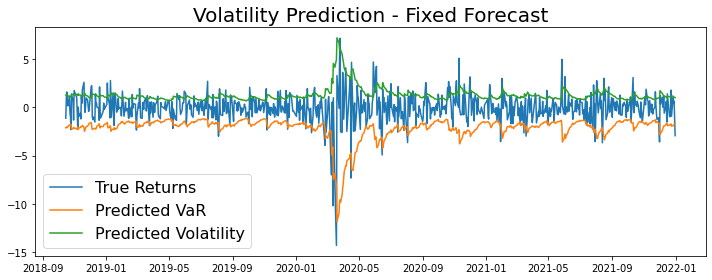

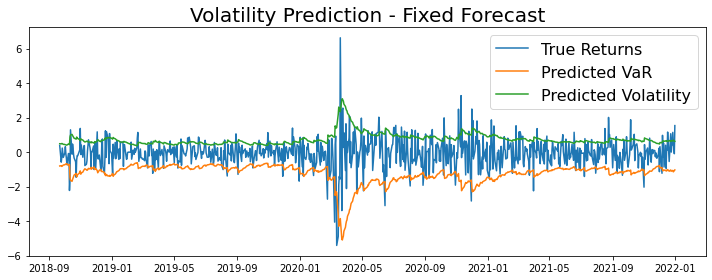

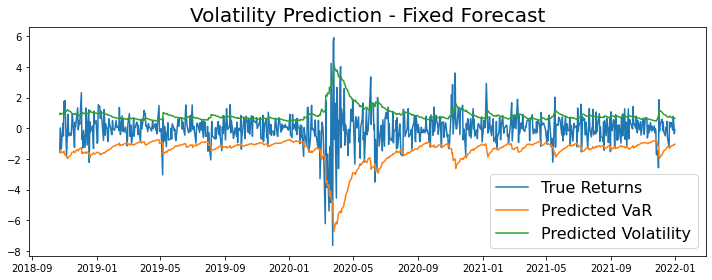

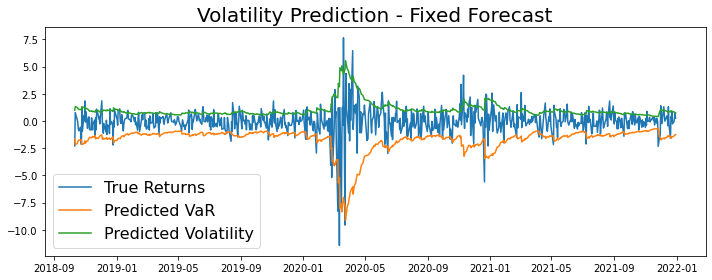

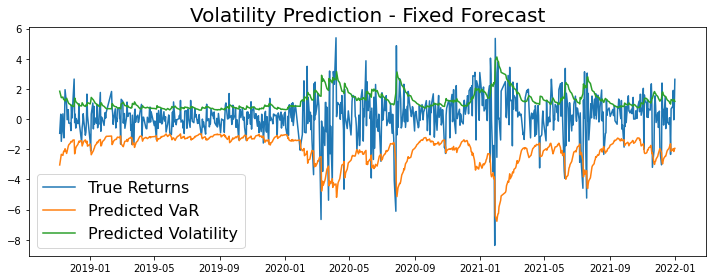

In [13]:
#Standard

#Philippines
plt.figure(figsize=(10,4))
plt.plot(PH['Returns'][:no_to_test(PH,prediction_size)])
plt.plot(-PH_fw_df_g)
plt.plot(PH_sigma_df_g)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('PH_'+name+'.png')


#Malaysia
plt.figure(figsize=(10,4))
plt.plot(MY['Returns'][:no_to_test(MY,prediction_size)])
plt.plot(-MY_fw_df_g)
plt.plot(MY_sigma_df_g)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('MY_'+name+'.png')

#Singapore
plt.figure(figsize=(10,4))
plt.plot(SG['Returns'][:no_to_test(SG,prediction_size)])
plt.plot(-SG_fw_df_g)
plt.plot(SG_sigma_df_g)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('SG_'+name+'.png')

#Thailand
plt.figure(figsize=(10,4))
plt.plot(TH['Returns'][:no_to_test(TH,prediction_size)])
plt.plot(-TH_fw_df_g)
plt.plot(TH_sigma_df_g)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('TH_'+name+'.png')

#Vietnam
plt.figure(figsize=(10,4))
plt.plot(VT['Returns'][:no_to_test(VT,prediction_size)])
plt.plot(-VT_fw_df_g)
plt.plot(VT_sigma_df_g)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('VT_'+name+'.png')

# Rolling Window
## Parameters

In [14]:
prediction_size = 0.2
alpha = 0.01
d = 1
p = 1
q = 1
dist = 'normal'
vol = 'GARCH'
name = 'RW-G-1'

In [15]:
def rolling_window(df, prediction_size, d, alpha, p, q, vol, dist):
    test_size = no_to_test(df, prediction_size)
    date_df = df.iloc[:test_size]
    date_df = date_df.reset_index()
    date_df = date_df.filter(['Date'])
    df = df[::-1]
    returns = df['Returns']
    sigma_df = np.zeros((test_size, 1))
    for i in range(test_size):
        temp_df = returns[:-(test_size-i)]
        model = arch_model(temp_df, p=p, q=q, vol = vol , rescale=None)
        fit = model.fit(disp='off')
        pred = fit.forecast(horizon=d, reindex = False)
        sigma_df[i] = (np.sqrt(pred.variance.values[-1,:][0]))
    sigma_df = pd.DataFrame(sigma_df[::-1], columns = ['Volatility'])
    sigma_df = pd.merge(date_df, sigma_df, left_index = True, right_index = True)
    sigma_df.set_index('Date', inplace = True)
    VaR_df = get_VaR_GARCH(df, alpha, sigma_df, dist)
    return sigma_df, VaR_df

PH_sigma_df_g, PH_rw_df_g = rolling_window(PH, prediction_size,d, alpha,p,q, vol, dist)
MY_sigma_df_g, MY_rw_df_g = rolling_window(MY, prediction_size,d, alpha,p,q, vol, dist)
SG_sigma_df_g, SG_rw_df_g = rolling_window(SG, prediction_size,d, alpha,p,q, vol, dist)
TH_sigma_df_g, TH_rw_df_g = rolling_window(TH, prediction_size,d, alpha,p,q, vol, dist)
VT_sigma_df_g, VT_rw_df_g = rolling_window(VT, prediction_size,d, alpha,p,q, vol, dist)


In [30]:
PH_rw_df_g.to_csv('/Users/raph/Desktop/Data/csv/PH_VaR_'+name+'.csv', index=True)
MY_rw_df_g.to_csv('/Users/raph/Desktop/Data/csv/MY_VaR_'+name+'.csv', index=True)
SG_rw_df_g.to_csv('/Users/raph/Desktop/Data/csv/SG_VaR_'+name+'.csv', index=True)
TH_rw_df_g.to_csv('/Users/raph/Desktop/Data/csv/TH_VaR_'+name+'.csv', index=True)
VT_rw_df_g.to_csv('/Users/raph/Desktop/Data/csv/VT_VaR_'+name+'.csv', index=True)

PH_sigma_df_g.to_csv('/Users/raph/Desktop/Data/csv/PH_sigma_'+name+'.csv', index=True)
MY_sigma_df_g.to_csv('/Users/raph/Desktop/Data/csv/MY_sigma_'+name+'.csv', index=True)
SG_sigma_df_g.to_csv('/Users/raph/Desktop/Data/csv/SG_sigma_'+name+'.csv', index=True)
TH_sigma_df_g.to_csv('/Users/raph/Desktop/Data/csv/TH_sigma_'+name+'.csv', index=True)
VT_sigma_df_g.to_csv('/Users/raph/Desktop/Data/csv/VT_sigma_'+name+'.csv', index=True)

# VaR Violation RW

In [33]:
#Philippines
PH, PH_N_rw_g = char_function(PH, PH_rw_df_g, prediction_size, name)

#Malaysia
MY, MY_N_rw_g = char_function(MY, MY_rw_df_g, prediction_size, name)

#Singapore
SG, SG_N_rw_g = char_function(SG, SG_rw_df_g, prediction_size, name)
    
#Thailand
TH, TH_N_rw_g = char_function(TH, TH_rw_df_g, prediction_size, name)

#Vietnam
VT, VT_N_rw_g = char_function(VT, VT_rw_df_g, prediction_size, name)

2

4

4

5

2

# Visualization of the Rolling Window

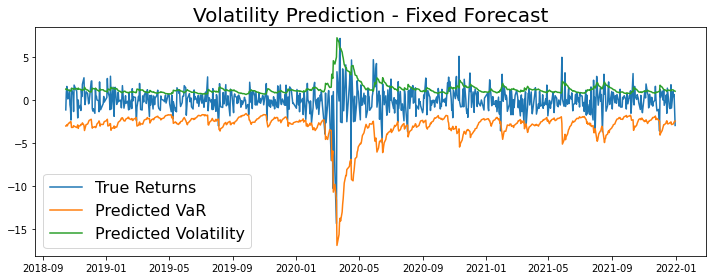

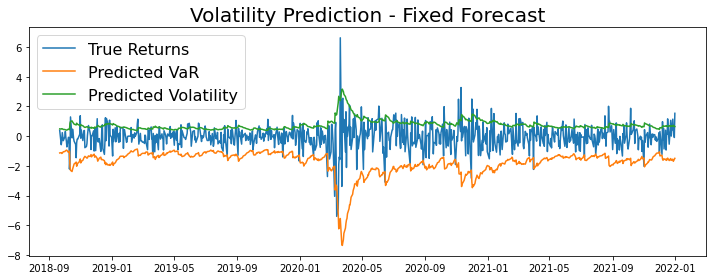

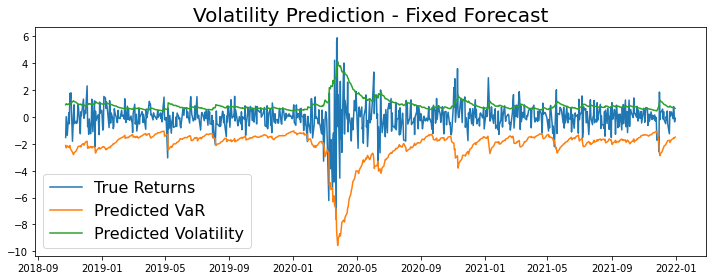

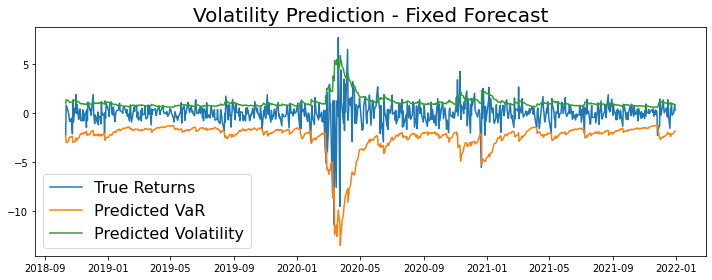

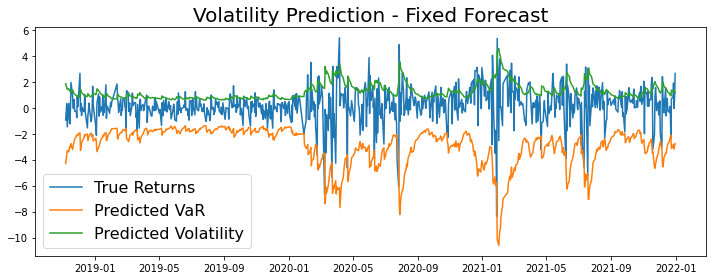

In [16]:
#Standard

#Philippines
plt.figure(figsize=(10,4))
plt.plot(PH['Returns'][:no_to_test(PH,prediction_size)])
plt.plot(-PH_rw_df_g)
plt.plot(PH_sigma_df_g)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('PH_'+name+'.png')


#Malaysia
plt.figure(figsize=(10,4))
plt.plot(MY['Returns'][:no_to_test(MY,prediction_size)])
plt.plot(-MY_rw_df_g)
plt.plot(MY_sigma_df_g)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('MY_'+name+'.png')

#Singapore
plt.figure(figsize=(10,4))
plt.plot(SG['Returns'][:no_to_test(SG,prediction_size)])
plt.plot(-SG_rw_df_g)
plt.plot(SG_sigma_df_g)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('SG_'+name+'.png')

#Thailand
plt.figure(figsize=(10,4))
plt.plot(TH['Returns'][:no_to_test(TH,prediction_size)])
plt.plot(-TH_rw_df_g)
plt.plot(TH_sigma_df_g)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('TH_'+name+'.png')

#Vietnam
plt.figure(figsize=(10,4))
plt.plot(VT['Returns'][:no_to_test(VT,prediction_size)])
plt.plot(-VT_rw_df_g)
plt.plot(VT_sigma_df_g)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('VT_'+name+'.png')

# Suffieincy of the Model


## Unconditional Coverage

In [60]:
def CI_UC(alpha, ss):
    '''
    The function returns an (1-alpha)% confidence interval for N
    
    PARAMETERS
    ----------
    alpha : float 
        The level of significance of the VaR
        (Assumes a value in between 0 and 1)
    ss : int
        The total number of entries in the data frame of the asset
        
    RETURNS
    -------
    CI : list
        The list is the (1-alpha)% confidence interval
    '''
    CI = []
    a = np.ceil(alpha*ss - (NormalDist().inv_cdf(1-alpha/2))*np.sqrt(ss*alpha*(1-alpha)))
    b = np.ceil(alpha*ss + (NormalDist().inv_cdf(1-alpha/2))*np.sqrt(ss*alpha*(1-alpha)))
    CI.append(a)
    CI.append(b)
    return CI


print(CI_UC(alpha,prediction_size))


[-0.0, 1.0]


## Chi-squared Test (1 DoF)

In [17]:
alpha = 0.05
chi2.ppf(1-alpha, df = 1)

3.841458820694124

## Conditional Coverage

In [62]:
chi2.ppf(1-alpha, df = 2)

18.420680743952584

# Parameters

In [34]:
alpha = 0.0001
entries1 = no_to_test(PH, prediction_size)
entries2 = no_to_test(MY, prediction_size)
entries3 = no_to_test(SG, prediction_size)
entries4 = no_to_test(TH, prediction_size)
entries5 = no_to_test(VT, prediction_size)
name_1 = 'FW-G-0.01%'
name_2 = 'RW-G-0.01%'


# Kupiec Test

In [35]:
def LR_kupiec(N, observations, alpha):
    p = alpha
    a =  -2*np.log((((1-p)**(observations - N))*(p**N))/(((1-N/observations)**(observations - N))*((N/observations)**N)))
    display(round(a,4))
    return a



#Philippines
PH_LRk_fw_g = LR_kupiec(PH_N_fw_g, entries1, alpha)
PH_LRk_rw_g = LR_kupiec(PH_N_rw_g, entries1, alpha)

#Malaysia
MY_LRk_fw_g = LR_kupiec(MY_N_fw_g, entries2, alpha)
MY_LRk_rw_g = LR_kupiec(MY_N_rw_g, entries2, alpha)

#Singapore
SG_LRk_fw_g = LR_kupiec(SG_N_fw_g, entries3, alpha)
SG_LRk_rw_g = LR_kupiec(SG_N_rw_g, entries3, alpha)

#Thailand
TH_LRk_fw_g = LR_kupiec(TH_N_fw_g, entries4, alpha)
TH_LRk_rw_g = LR_kupiec(TH_N_rw_g, entries4, alpha)

#Vietnam
VT_LRk_fw_g = LR_kupiec(VT_N_fw_g, entries5, alpha)
VT_LRk_rw_g = LR_kupiec(VT_N_rw_g, entries5, alpha)

9.1326

9.1326

23.3681

23.3681

23.446

23.446

31.7793

31.7793

9.0836

9.0836

# Christoffersen Test
## Part 1

In [36]:
def no_of_periods(df, name):
    n00 = 0
    n01 = 0
    n10 = 0
    n11 = 0
    violations = df[name].dropna()[::-1]
    v_p = violations[0]
    i = 1
    while i < len(violations):
        if v_p == violations[i] and v_p == 0:
            n00 += 1
        elif v_p != violations[i] and v_p == 0:
            n01 += 1
        elif v_p != violations[i] and v_p == 1:
            n10 += 1
        else:
            n11 += 1
        v_p = violations[i]
        i += 1 
    return n00, n01, n10, n11

## Part 2

In [37]:
def LR_ind(df, name, LR_pof):
    n00, n01, n10, n11 = no_of_periods(df, name)
    pi_0 = n01/(n00+n01)
    pi_1 = n11/(n10+n11)
    pi = (n01+n11)/(n00+n01+n10+n11)
    LR_ind = -2*np.log((((1-pi)**(n00+n01))*(pi**(n01+n11)))/(((1-pi_0)**n00)*(pi_0**n01)*((1-pi_1)**n10)*(pi_1**n11)))
    LR_cc = LR_ind+LR_pof
    display(round(LR_cc,4))
    return LR_ind, LR_cc

#Philippines
PH_LRcci_fw_g, PH_LRcc_fw_g = LR_ind(PH, name_1, PH_LRk_fw_g)
PH_LRcci_rw_g, PH_LRcc_rw_g = LR_ind(PH, name_2, PH_LRk_rw_g)
#Malaysia
MY_LRcci_fw_g, MY_LRcc_fw_g = LR_ind(MY, name_1, MY_LRk_fw_g)
MY_LRcci_rw_g, MY_LRcc_rw_g = LR_ind(MY, name_2, MY_LRk_rw_g)
#Singapore
SG_LRcci_fw_g,SG_LRcc_fw_g = LR_ind(SG, name_1, SG_LRk_fw_g)
SG_LRcci_rw_g,SG_LRcc_rw_g = LR_ind(SG, name_2, SG_LRk_rw_g)
#Thailand
TH_LRcci_fw_g,TH_LRcc_fw_g = LR_ind(TH, name_1, TH_LRk_fw_g)
TH_LRcci_rw_g,TH_LRcc_rw_g = LR_ind(TH, name_2, TH_LRk_rw_g)
#Vietnam
VT_LRcci_fw_g,VT_LRcc_fw_g = LR_ind(VT, name_1, VT_LRk_fw_g)
VT_LRcci_rw_g,VT_LRcc_rw_g = LR_ind(VT, name_2, VT_LRk_rw_g)

9.1429

9.1429

23.4078

23.4078

23.4861

23.4861

31.8438

31.8438

9.0938

9.0938

### Conditional

In [ ]:
# def sigma_c(df_1, df_2, model_param, p, q):
#     omega = model_param[1]
#     if p != None:
#         i = 0
#         alpha_lst = []
#         while i < len(model_param) - (q+2):
#             alpha = model_param[i+2]
#             alpha_lst.append(alpha)
#             i += 1
#     if q != None:
#         i = 0
#         beta_lst = []
#         while i < len(model_param) - (p+2):
#             beta = model_param[i+2+p]
#             beta_lst.append(beta)
#             i += 1
#     sigma = omega
#     i = 0
#     for alpha in alpha_lst:
#         sigma += alpha*(df_1.iloc[i]**2)
#         i += 1
#     i = 0
#     for beta in beta_lst:
#         sigma += beta*(df_2.iloc[i]**2)
#         i += 1
#     return np.sqrt(sigma)


# PH_sigma_c = sigma_c(PH_resid_g, PH_condv_g, PH_params_g, p = 1, q = 1)
# MY_sigma_c = sigma_c(MY_resid_g, MY_condv_g, MY_params_g, p = 1, q = 1)
# SG_sigma_c = sigma_c(SG_resid_g, SG_condv_g, SG_params_g, p = 1, q = 1)
# TH_sigma_c = sigma_c(TH_resid_g, TH_condv_g, TH_params_g, p = 1, q = 1)
# VT_sigma_c = sigma_c(VT_resid_g, VT_condv_g, VT_params_g, p = 1, q = 1)

### Unconditional (May not apply for all cases)

In [ ]:
# def sigma_u(params):
#     i = 0
#     total = 0
#     while i < len(params):
#         if i == 0:
#             mu = params[i]
#         elif i == 1:
#             omega = params[i]
#         else:
#             total += params[i]
#         i += 1
#     return np.sqrt(omega/(1-total))
        
# PH_sigma_u = sigma_u(PH_params_g)
# MY_sigma_u = sigma_u(MY_params_g)
# SG_sigma_u = sigma_u(SG_params_g)
# TH_sigma_u = sigma_u(TH_params_g)
# VT_sigma_u = sigma_u(VT_params_g)

<ipython-input-9-82ca9fd280ea>:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(omega/(1-total))
